In [7]:
# Import libaries
import os
import mysql.connector
import pandas as pd
import os
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## Getting Data from MySQL Database

In [8]:
def get_data(query):
    host = os.environ.get("MYSQL_HOST", "localhost")
    port = os.environ.get("MYSQL_PORT", "3306")
    dbname = os.environ.get("MYSQL_DBNAME", "test")
    user = os.environ.get("MYSQL_USER", "root")
    password = os.environ.get("MYSQL_PASSWORD", "")

    try:
        conn = mysql.connector.connect(
            host=host,
            port=port,
            user=user,
            password=password,
            database=dbname
        )
        if conn.is_connected():
            # Create a cursor
            cursor = conn.cursor()
            
            # Execute the query
            cursor.execute(query)
            
            # Fetch the results into a Pandas DataFrame
            result = cursor.fetchall()
            df = pd.DataFrame(result, columns=cursor.column_names)
            return df
            
            print("Query result:")
            print(df)
        else:
            print("Connection to MySQL database failed.")
    except mysql.connector.Error as err:
        print(f"Error: {err}")



In [9]:
# Create regression tree

# Getting charger data from MySQL database with custom query
query = "SELECT canton, COUNT(*) AS count FROM charger_data_with_canton GROUP BY canton ORDER BY canton ASC"

# Get data from MySQL database
df_canton_count = get_data(query)

query = "SELECT * FROM canton_data ORDER By canton ASC"

df_canton_data = get_data(query)

# Merge dataframes
df = pd.merge(df_canton_data, df_canton_count, on='canton')

X_train, X_test, y_train, y_test = train_test_split(df[['popDens',
                                                        'medianIncome']], 
                                                        df['count'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
    popDens  medianIncome
11    357.3         74474
14     35.3         71500
8      80.5         72101
13    335.6         71986
2      95.2         84571 

y_train:
11    310
14    119
8      69
13    276
2      24
Name: count, dtype: int64


# Fit the regression tree model

In [10]:


# Create decision tree regressor object
reg = DecisionTreeRegressor(random_state=20, max_depth=5)

# Train decision tree regressor
reg = reg.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = reg.predict(X_test)

# Calculate coefficient of determination (R-squared)

In [11]:


# Calculate coefficient of determination
print('R-squared:', r2_score(y_test, y_pred).round(4))

R-squared: 0.159


In [12]:
# Text representation of the regression tree
text_representation = tree.export_text(reg, 
                                       feature_names=list(X_train.columns))

# Print text_representation
print(text_representation)

|--- popDens <= 654.30
|   |--- popDens <= 231.65
|   |   |--- popDens <= 188.85
|   |   |   |--- medianIncome <= 80278.00
|   |   |   |   |--- popDens <= 48.10
|   |   |   |   |   |--- value: [119.00]
|   |   |   |   |--- popDens >  48.10
|   |   |   |   |   |--- value: [78.67]
|   |   |   |--- medianIncome >  80278.00
|   |   |   |   |--- value: [24.00]
|   |   |--- popDens >  188.85
|   |   |   |--- value: [246.00]
|   |--- popDens >  231.65
|   |   |--- medianIncome <= 72693.00
|   |   |   |--- popDens <= 310.70
|   |   |   |   |--- value: [128.00]
|   |   |   |--- popDens >  310.70
|   |   |   |   |--- value: [276.00]
|   |   |--- medianIncome >  72693.00
|   |   |   |--- medianIncome <= 74050.50
|   |   |   |   |--- medianIncome <= 73243.00
|   |   |   |   |   |--- value: [844.00]
|   |   |   |   |--- medianIncome >  73243.00
|   |   |   |   |   |--- value: [707.00]
|   |   |   |--- medianIncome >  74050.50
|   |   |   |   |--- value: [310.00]
|--- popDens >  654.30
|   |--- popD

# Visualize the regression tree

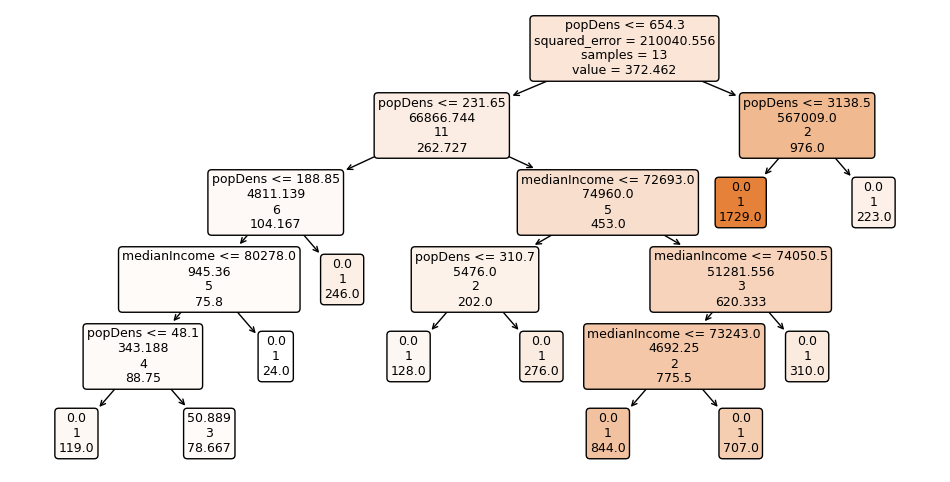

In [13]:


fig = plt.figure(figsize=(12,6))
_ = tree.plot_tree(reg, 
                   feature_names=list(X_train.columns),  
                   class_names=['price'],
                   filled=True,
                   fontsize=9,
                   label='root',
                   rounded=True)

# Create random forest regression

In [15]:


# Create train and test samples (the names X2_ and y2_ were used because X_ and y_ were already used above)
X2_train, X2_test, y2_train, y2_test = train_test_split(df[[ 'popDens',
                                                            'medianIncome']], 
                                                            df['count'], 
                                                            test_size=0.20, 
                                                            random_state=42)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
    popDens  medianIncome
11    357.3         74474
14     35.3         71500
8      80.5         72101
13    335.6         71986
2      95.2         84571 

y2_train:
11    310
14    119
8      69
13    276
2      24
Name: count, dtype: int64


# Fit the random forest regression model

In [16]:


X, y = make_regression(n_features=4, n_informative=2,
                       random_state=5, shuffle=False)


reg_rf = RandomForestRegressor(n_estimators=500, 
                               max_depth=10, 
                               random_state=5)
reg_rf.fit(X2_train, y2_train)

# Calculate coefficient of determination (R-squared)
print('R-squared:', reg_rf.score(X2_test, y2_test).round(4))

R-squared: -0.1476


Index(['popDens', 'medianIncome'], dtype='object')
[0.62889679 0.37110321]


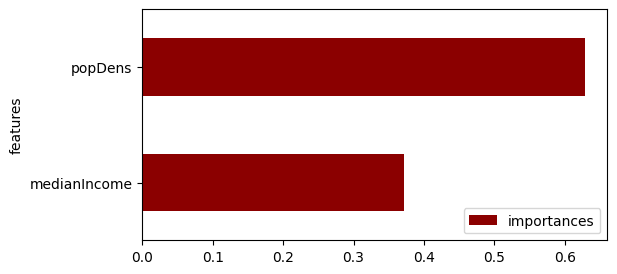

In [17]:
cols = X2_train.columns

# Derive feature importance from random forest
importances = reg_rf.feature_importances_
std         = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

plt.show()